# Exploring Classical Limits of Quantum Circuit Verification using SAT and SMT
- Z3/SMT-based unitary equivalence checks
- Stabilizer-style (Clifford) checks
- Optional PySAT Boolean CNF check (prototype)
- Benchmarks + plots




If PySAT fails to install on Windows / Python 3.13, use Python 3.11 in a conda env:

```powershell
conda create -n qsmt python=3.11 -y
conda activate qsmt
python -m pip install qiskit z3-solver matplotlib numpy pandas
python -m pip install python-sat
```

This notebook **still runs without PySAT** (it will skip PySAT sections).


In [1]:
# Core imports
import time
import itertools
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import matplotlib.pyplot as plt

from z3 import Solver, Real, sat

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

import pandas as pd
from IPython.display import display, Markdown

# Optional PySAT
try:
    from pysat.solvers import Glucose4, Minisat22
    from pysat.formula import CNF
    PYSAT_AVAILABLE = True
except Exception as e:
    PYSAT_AVAILABLE = False
    PYSAT_IMPORT_ERROR = repr(e)

PYSAT_AVAILABLE, (None if PYSAT_AVAILABLE else PYSAT_IMPORT_ERROR)


(True, None)

## 1) Data structures


In [2]:
@dataclass
class VerificationResult:
    """Results from circuit equivalence verification."""
    equivalent: bool
    solve_time: float
    num_clauses: int
    num_variables: int
    method: str
    details: str
    phase_used: Optional[str] = None


In [3]:
class QuantumSATVerifier:
    """SMT-based verifier for quantum circuit equivalence."""
    
    def __init__(self, num_qubits: int, tolerance: float = 1e-10):
        self.n = num_qubits
        self.dim = 2 ** num_qubits
        self.tolerance = tolerance
        self.solver = Solver()

    def encode_unitary(self, circuit: QuantumCircuit, name_prefix: str):
        U_real = [[Real(f'{name_prefix}_r_{i}_{j}') for j in range(self.dim)] for i in range(self.dim)]
        U_imag = [[Real(f'{name_prefix}_i_{i}_{j}') for j in range(self.dim)] for i in range(self.dim)]

        actual_U = Operator(circuit).data
        for i in range(self.dim):
            for j in range(self.dim):
                self.solver.add(U_real[i][j] == float(actual_U[i, j].real))
                self.solver.add(U_imag[i][j] == float(actual_U[i, j].imag))
        return U_real, U_imag, actual_U

    def verify_equivalence(self, circuit1: QuantumCircuit, circuit2: QuantumCircuit, check_global_phase: bool = True) -> VerificationResult:
        start_time = time.time()
        self.solver = Solver()

        U1_r, U1_i, U1 = self.encode_unitary(circuit1, 'U1')
        U2_r, U2_i, U2 = self.encode_unitary(circuit2, 'U2')

        def add_close(slv: Solver, diff_r, diff_i):
            slv.add(diff_r * diff_r + diff_i * diff_i < self.tolerance)

        if not check_global_phase:
            for i in range(self.dim):
                for j in range(self.dim):
                    add_close(self.solver, U1_r[i][j] - U2_r[i][j], U1_i[i][j] - U2_i[i][j])
            sat_result = (self.solver.check() == sat)
            solve_time = time.time() - start_time
            return VerificationResult(
                equivalent=sat_result,
                solve_time=solve_time,
                num_clauses=len(self.solver.assertions()),
                num_variables=self.dim * self.dim * 2,
                method='Z3 SMT Solver (numeric unitary constraints)',
                details=f'Entrywise closeness on {self.dim}x{self.dim} unitaries'
            )

        phases = [((1, 0), '1'), ((-1, 0), '-1'), ((0, 1), 'i'), ((0, -1), '-i')]
        base_assertions = list(self.solver.assertions())

        for (pr, pi), label in phases:
            slv = Solver()
            slv.add(base_assertions)

            for i in range(self.dim):
                for j in range(self.dim):
                    expected_real = pr * U2_r[i][j] - pi * U2_i[i][j]
                    expected_imag = pr * U2_i[i][j] + pi * U2_r[i][j]
                    add_close(slv, U1_r[i][j] - expected_real, U1_i[i][j] - expected_imag)

            if slv.check() == sat:
                solve_time = time.time() - start_time
                return VerificationResult(
                    equivalent=True,
                    solve_time=solve_time,
                    num_clauses=len(slv.assertions()),
                    num_variables=self.dim * self.dim * 2,
                    method='Z3 SMT Solver (restricted global phase: ±1, ±i)',
                    details=f'Matched with phase {label}',
                    phase_used=label
                )

        solve_time = time.time() - start_time
        return VerificationResult(
            equivalent=False,
            solve_time=solve_time,
            num_clauses=len(base_assertions) + self.dim * self.dim,
            num_variables=self.dim * self.dim * 2,
            method='Z3 SMT Solver (restricted global phase: ±1, ±i)',
            details='No phase in {±1, ±i} matched within tolerance',
            phase_used=None
        )


In [4]:
class CliffordSATVerifier:
    def __init__(self, num_qubits: int):
        self.n = num_qubits

    def _get_qubit_indices(self, circuit, instruction):
        try:
            return [circuit.qubits.index(q) for q in instruction.qubits]
        except (AttributeError, TypeError):
            try:
                return [q.index for q in instruction.qubits]
            except AttributeError:
                return [i for i, _ in enumerate(instruction.qubits)]

    def _pauli_multiply(self, p1: str, p2: str) -> str:
        if p1 == 'I':
            return p2
        if p2 == 'I':
            return p1
        if p1 == p2:
            return 'I'
        products = {
            ('X', 'Y'): 'Z', ('Y', 'X'): 'Z',
            ('Y', 'Z'): 'X', ('Z', 'Y'): 'X',
            ('Z', 'X'): 'Y', ('X', 'Z'): 'Y'
        }
        return products.get((p1, p2), 'I')

    def circuit_to_stabilizers(self, circuit: QuantumCircuit) -> frozenset:
        stabilizers = []
        for i in range(self.n):
            stab = ['I'] * self.n
            stab[i] = 'Z'
            stabilizers.append(tuple(stab))
        for i in range(self.n):
            stab = ['I'] * self.n
            stab[i] = 'X'
            stabilizers.append(tuple(stab))

        for instruction in circuit.data:
            stabilizers = self._update_stabilizers(stabilizers, instruction, circuit)
        return frozenset(stabilizers)

    def _update_stabilizers(self, stabilizers: List[Tuple], instruction, circuit) -> List[Tuple]:
        updated = []
        gate_name = instruction.operation.name
        qubits = self._get_qubit_indices(circuit, instruction)

        for stab in stabilizers:
            new_stab = list(stab)

            if gate_name == 'h':
                q = qubits[0]
                if stab[q] == 'X':
                    new_stab[q] = 'Z'
                elif stab[q] == 'Z':
                    new_stab[q] = 'X'

            elif gate_name == 's':
                q = qubits[0]
                if stab[q] == 'X':
                    new_stab[q] = 'Y'
                elif stab[q] == 'Y':
                    new_stab[q] = 'X'

            elif gate_name == 'sdg':
                q = qubits[0]
                if stab[q] == 'X':
                    new_stab[q] = 'Y'
                elif stab[q] == 'Y':
                    new_stab[q] = 'X'

            elif gate_name in ('cx', 'cnot'):
                ctrl, targ = qubits
                ctrl_pauli = new_stab[ctrl]
                targ_pauli = new_stab[targ]

                if ctrl_pauli in ('X', 'Y'):
                    new_stab[targ] = self._pauli_multiply(targ_pauli, 'X')

                if targ_pauli in ('Z', 'Y'):
                    new_stab[ctrl] = self._pauli_multiply(ctrl_pauli, 'Z')

            updated.append(tuple(new_stab))

        return updated

    def verify_clifford_equivalence(self, circuit1: QuantumCircuit, circuit2: QuantumCircuit) -> VerificationResult:
        start_time = time.time()
        stab1 = self.circuit_to_stabilizers(circuit1)
        stab2 = self.circuit_to_stabilizers(circuit2)
        equivalent = (stab1 == stab2)
        solve_time = time.time() - start_time
        return VerificationResult(
            equivalent=equivalent,
            solve_time=solve_time,
            num_clauses=0,
            num_variables=self.n * 2,
            method='Stabilizer Formalism (polynomial-time sketch)',
            details=f'Compared stabilizer sets with {len(stab1)} and {len(stab2)} generators'
        )


In [5]:
class PySATVerifier:
    def __init__(self, num_qubits: int, precision_bits: int = 8):
        if not PYSAT_AVAILABLE:
            raise RuntimeError(f'PySAT not available: {PYSAT_IMPORT_ERROR}')
        self.n = num_qubits
        self.precision = precision_bits
        self.var_counter = 1
        self.cnf = CNF()

    def _encode_equality_constraint(self, vars1: List[int], vars2: List[int]) -> None:
        for v1, v2 in zip(vars1, vars2):
            self.cnf.append([v1, -v2])
            self.cnf.append([-v1, v2])

    def _get_qubit_indices(self, circuit, instruction):
        try:
            return [circuit.qubits.index(q) for q in instruction.qubits]
        except (AttributeError, TypeError):
            try:
                return [q.index for q in instruction.qubits]
            except AttributeError:
                return [i for i, _ in enumerate(instruction.qubits)]

    def _add_gate_constraints(self, gate_name: str, qubits: List[int], old_stabs: List, new_stabs: List) -> None:
        # Placeholder: identity-like propagation so the demo runs.
        for old_stab, new_stab in zip(old_stabs, new_stabs):
            for i in range(self.n):
                self._encode_equality_constraint([old_stab[i][0], old_stab[i][1]], [new_stab[i][0], new_stab[i][1]])

    def _encode_circuit_evolution(self, circuit: QuantumCircuit, init_stabilizers: List) -> List:
        current_stabs = init_stabilizers.copy()
        for instruction in circuit.data:
            gate_name = instruction.operation.name
            qubits = self._get_qubit_indices(circuit, instruction)

            new_stabs = []
            for stab in current_stabs:
                new_stab = []
                for _ in range(self.n):
                    new_bit0 = self.var_counter
                    new_bit1 = self.var_counter + 1
                    self.var_counter += 2
                    new_stab.append((new_bit0, new_bit1))
                new_stabs.append(new_stab)

            self._add_gate_constraints(gate_name, qubits, current_stabs, new_stabs)
            current_stabs = new_stabs
        return current_stabs

    def verify_clifford_circuit_boolean(self, circuit1: QuantumCircuit, circuit2: QuantumCircuit) -> VerificationResult:
        start_time = time.time()
        self.cnf = CNF()
        self.var_counter = 1

        init_stabilizers = []
        for _ in range(self.n * 2):
            stab_vars = []
            for _q in range(self.n):
                bit0 = self.var_counter
                bit1 = self.var_counter + 1
                self.var_counter += 2
                stab_vars.append((bit0, bit1))
            init_stabilizers.append(stab_vars)

        stab1_final = self._encode_circuit_evolution(circuit1, init_stabilizers)
        stab2_final = self._encode_circuit_evolution(circuit2, init_stabilizers)

        for s1, s2 in zip(stab1_final, stab2_final):
            for (b10, b11), (b20, b21) in zip(s1, s2):
                self._encode_equality_constraint([b10, b11], [b20, b21])

        solver = Glucose4()
        for clause in self.cnf.clauses:
            solver.add_clause(clause)
        satisfiable = solver.solve()
        solve_time = time.time() - start_time

        return VerificationResult(
            equivalent=satisfiable,
            solve_time=solve_time,
            num_clauses=len(self.cnf.clauses),
            num_variables=self.var_counter - 1,
            method='PySAT Boolean CNF (Glucose4) [prototype]',
            details=f'CNF with {len(self.cnf.clauses)} clauses, {self.var_counter - 1} vars'
        )


In [6]:
def show_side_by_side(qc1: QuantumCircuit, qc2: QuantumCircuit, title: str = ''):
    display(Markdown(f"### {title}"))
    print('Circuit A')
    print(qc1.draw(output='text'))
    print('\nCircuit B')
    print(qc2.draw(output='text'))

    U1 = Operator(qc1).data
    U2 = Operator(qc2).data
    np.set_printoptions(precision=3, suppress=True)
    print('\nUnitary(A):')
    print(U1)
    print('\nUnitary(B):')
    print(U2)
    print('\nFrobenius norm ||U(A)-U(B)||:', np.linalg.norm(U1 - U2))


In [7]:
tests = []

# [1] H-X-H = Z
qc1 = QuantumCircuit(1); qc1.h(0); qc1.x(0); qc1.h(0)
qc2 = QuantumCircuit(1); qc2.z(0)
tests.append(('H X H  vs  Z', qc1, qc2, True))

# [2] CNOT = H·CZ·H
qc1 = QuantumCircuit(2); qc1.cx(0, 1)
qc2 = QuantumCircuit(2); qc2.h(1); qc2.cz(0, 1); qc2.h(1)
tests.append(('CNOT  vs  H·CZ·H', qc1, qc2, True))

# [3] SWAP via 3 CNOTs
qc1 = QuantumCircuit(2); qc1.swap(0, 1)
qc2 = QuantumCircuit(2); qc2.cx(0, 1); qc2.cx(1, 0); qc2.cx(0, 1)
tests.append(('SWAP  vs  3×CNOT', qc1, qc2, False))

# [4] Sdg H S ≡ X (up to restricted phase)
qc1 = QuantumCircuit(1); qc1.sdg(0); qc1.h(0); qc1.s(0)
qc2 = QuantumCircuit(1); qc2.x(0)
tests.append(('Sdg·H·S  vs  X', qc1, qc2, True))

rows = []
for name, a, b, allow_phase in tests:
    show_side_by_side(a, b, title=name)
    v = QuantumSATVerifier(num_qubits=a.num_qubits)
    r_smt = v.verify_equivalence(a, b, check_global_phase=allow_phase)
    v_cl = CliffordSATVerifier(num_qubits=a.num_qubits)
    r_cl = v_cl.verify_clifford_equivalence(a, b)

    rows.append({
        'Test': name,
        'Qubits': a.num_qubits,
        'SMT equivalent': r_smt.equivalent,
        'SMT phase': r_smt.phase_used,
        'SMT time (ms)': r_smt.solve_time * 1000,
        'SMT clauses': r_smt.num_clauses,
        'Clifford equivalent': r_cl.equivalent,
        'Clifford time (ms)': r_cl.solve_time * 1000
    })

df = pd.DataFrame(rows)
display(df)


### H X H  vs  Z

Circuit A
   ┌───┐┌───┐┌───┐
q: ┤ H ├┤ X ├┤ H ├
   └───┘└───┘└───┘

Circuit B
   ┌───┐
q: ┤ Z ├
   └───┘

Unitary(A):
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]

Unitary(B):
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]

Frobenius norm ||U(A)-U(B)||: 3.1401849173675503e-16


### CNOT  vs  H·CZ·H

Circuit A
          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

Circuit B
                  
q_0: ──────■──────
     ┌───┐ │ ┌───┐
q_1: ┤ H ├─■─┤ H ├
     └───┘   └───┘

Unitary(A):
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]

Unitary(B):
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]

Frobenius norm ||U(A)-U(B)||: 4.440892098500626e-16


### SWAP  vs  3×CNOT

Circuit A
        
q_0: ─X─
      │ 
q_1: ─X─
        

Circuit B
          ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘

Unitary(A):
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

Unitary(B):
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

Frobenius norm ||U(A)-U(B)||: 0.0


### Sdg·H·S  vs  X

Circuit A
   ┌─────┐┌───┐┌───┐
q: ┤ Sdg ├┤ H ├┤ S ├
   └─────┘└───┘└───┘

Circuit B
   ┌───┐
q: ┤ X ├
   └───┘

Unitary(A):
[[ 0.707+0.j     0.   -0.707j]
 [ 0.   +0.707j -0.707+0.j   ]]

Unitary(B):
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

Frobenius norm ||U(A)-U(B)||: 2.0


,Test,Qubits,SMT equivalent,SMT phase,SMT time (ms),SMT clauses,Clifford equivalent,Clifford time (ms)
0,H X H vs Z,1,True,1,5.348682,20,True,0.044346
1,CNOT vs H·CZ·H,2,True,1,9.186983,80,False,0.045538
2,SWAP vs 3×CNOT,2,True,None,5.523682,80,True,0.032425
3,Sdg·H·S vs X,1,False,None,6.756067,20,False,0.023842


In [8]:
if not PYSAT_AVAILABLE:
    print('PySAT not available, skipping demo. Import error:', PYSAT_IMPORT_ERROR)
else:
    print('[PySAT Demo] CNOT vs H·CZ·H')
    qc1 = QuantumCircuit(2); qc1.cx(0, 1)
    qc2 = QuantumCircuit(2); qc2.h(1); qc2.cz(0, 1); qc2.h(1)
    pysat_verifier = PySATVerifier(num_qubits=2)
    result = pysat_verifier.verify_clifford_circuit_boolean(qc1, qc2)
    print('Result:', 'EQUIVALENT' if result.equivalent else 'NOT EQUIVALENT')
    print('Method:', result.method)
    print('Clauses:', result.num_clauses, 'Variables:', result.num_variables)
    print('Time (ms):', result.solve_time * 1000)


[PySAT Demo] CNOT vs H·CZ·H
Result: EQUIVALENT
Method: PySAT Boolean CNF (Glucose4) [prototype]
Clauses: 160 Variables: 80
Time (ms): 0.3192424774169922


##  Benchmark Suite (scaling + plots)


In [9]:
class BenchmarkSuite:
    def __init__(self):
        self.results = {
            'qubits': [],
            'z3_times': [],
            'stabilizer_times': [],
            'pysat_times': [],
            'clauses': [],
            'variables': []
        }

    def _random_clifford_circuit(self, n: int, depth: int) -> QuantumCircuit:
        qc = QuantumCircuit(n)
        clifford_gates = ['h', 's', 'sdg']
        for _ in range(depth):
            gate = np.random.choice(clifford_gates)
            qubit = np.random.randint(n)
            getattr(qc, gate)(qubit)
            if n > 1 and np.random.random() < 0.3:
                ctrl = np.random.randint(n)
                targ = np.random.randint(n)
                if ctrl != targ:
                    qc.cx(ctrl, targ)
        return qc

    def benchmark_scaling(self, max_qubits: int = 6, runs_per_size: int = 3) -> Dict:
        print('Benchmarking scaling...')
        for n in range(1, max_qubits + 1):
            z3_times, stab_times, pysat_times = [], [], []
            clauses_list, vars_list = [], []

            for _ in range(runs_per_size):
                qc = self._random_clifford_circuit(n, depth=2*n)

                # Z3
                try:
                    verifier_z3 = QuantumSATVerifier(num_qubits=n)
                    r = verifier_z3.verify_equivalence(qc, qc, check_global_phase=False)
                    z3_times.append(r.solve_time)
                    clauses_list.append(r.num_clauses)
                    vars_list.append(r.num_variables)
                except Exception:
                    z3_times.append(float('inf'))

                # Stabilizer
                try:
                    verifier_stab = CliffordSATVerifier(num_qubits=n)
                    r = verifier_stab.verify_clifford_equivalence(qc, qc)
                    stab_times.append(r.solve_time)
                except Exception:
                    stab_times.append(float('inf'))

                # PySAT (small)
                if PYSAT_AVAILABLE and n <= 3:
                    try:
                        verifier_pysat = PySATVerifier(num_qubits=n)
                        r = verifier_pysat.verify_clifford_circuit_boolean(qc, qc)
                        pysat_times.append(r.solve_time)
                    except Exception:
                        pysat_times.append(float('inf'))
                else:
                    pysat_times.append(np.nan)

            avg_z3 = np.mean([t for t in z3_times if t != float('inf')])
            avg_stab = np.mean([t for t in stab_times if t != float('inf')])
            valid_pysat = [t for t in pysat_times if not np.isnan(t) and t != float('inf')]
            avg_pysat = (np.mean(valid_pysat) if len(valid_pysat) else None)

            self.results['qubits'].append(n)
            self.results['z3_times'].append(avg_z3)
            self.results['stabilizer_times'].append(avg_stab)
            self.results['pysat_times'].append(avg_pysat)
            self.results['clauses'].append(float(np.mean(clauses_list)) if clauses_list else None)
            self.results['variables'].append(float(np.mean(vars_list)) if vars_list else None)

            print(f'n={n}: Z3={avg_z3:.4g}s, Stabilizer={avg_stab:.4g}s, PySAT={avg_pysat}')

        return self.results

    def visualize_results(self):
        qubits = self.results['qubits']
        z3t = self.results['z3_times']
        stabt = self.results['stabilizer_times']
        pysatt = self.results['pysat_times']

        plt.figure(figsize=(8, 5))
        plt.semilogy(qubits, z3t, marker='o', label='Z3 SMT')
        plt.semilogy(qubits, stabt, marker='s', label='Stabilizer')
        if any(t is not None for t in pysatt):
            pq = [q for q, t in zip(qubits, pysatt) if t is not None]
            pt = [t for t in pysatt if t is not None]
            plt.semilogy(pq, pt, marker='^', label='PySAT (prototype)')

        plt.xlabel('Number of Qubits')
        plt.ylabel('Solve Time (s)')
        plt.title('Verification Time Scaling')
        plt.grid(True, which='both', alpha=0.3)
        plt.legend()
        plt.show()

        df = pd.DataFrame(self.results)
        display(df)
        return df


Benchmarking scaling...
n=1: Z3=0.002901s, Stabilizer=2.678e-05s, PySAT=9.592374165852864e-05
n=2: Z3=0.006163s, Stabilizer=5.945e-05s, PySAT=0.00041476885477701825
n=3: Z3=0.01791s, Stabilizer=6.318e-05s, PySAT=0.0011069774627685547
n=4: Z3=0.06508s, Stabilizer=8.837e-05s, PySAT=None
n=5: Z3=0.2633s, Stabilizer=0.0001643s, PySAT=None
n=6: Z3=1.083s, Stabilizer=0.0001934s, PySAT=None


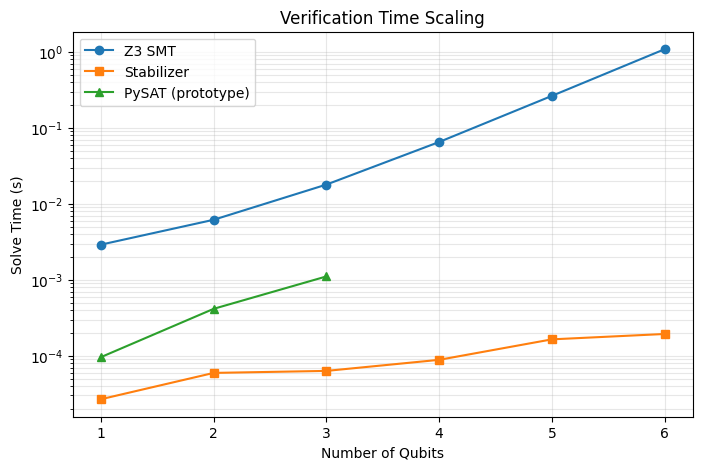

,qubits,z3_times,stabilizer_times,pysat_times,clauses,variables
0,1,0.002901,0.000027,0.000096,20.0,8.0
1,2,0.006163,0.000059,0.000415,80.0,32.0
2,3,0.017908,0.000063,0.001107,320.0,128.0
3,4,0.065084,0.000088,NaN,1280.0,512.0
4,5,0.263263,0.000164,NaN,5120.0,2048.0
5,6,1.082659,0.000193,NaN,20480.0,8192.0


In [10]:
benchmark = BenchmarkSuite()
results = benchmark.benchmark_scaling(max_qubits=6, runs_per_size=3)
df_bench = benchmark.visualize_results()


## Interpretation 

- Z3 uses explicit unitaries (size 2^n × 2^n) → grows exponentially.
- Stabilizer-style reasoning stays compact for Clifford circuits.


